In [1]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from eipy.metrics import fmax_score
from sklearn.metrics import roc_auc_score, matthews_corrcoef, f1_score, fbeta_score, precision_score, recall_score
import pandas as pd
import numpy as np
import eipy.ei as e
import tensorflow as tf
import keras
from keras.callbacks import EarlyStopping, TensorBoard, Callback
import keras.backend as K
from keras.models import Sequential
from keras.layers import LSTM,Dense, Bidirectional, GRU, Dropout, LayerNormalization, BatchNormalization, SimpleRNN
from keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from tensorboard import notebook
from tqdm import tqdm
import concurrent.futures
import inspect
import pickle as pkl
import warnings
import longitudinal_tadpole.pipeline as p
from eipy.multiclass_metrics import alt_nested_threshold_fmax
from eipy.multiclass_metrics import decide_with_thresholds
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import longitudinal_tadpole.pipeline as p

/Users/susmaa01/Documents/eipy/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
cwd = os.getcwd()
with open(f"/Users/susmaa01/Documents/eipy/longitudinal_tadpole/tadpole_data/tadpole_data_time_imptn_norm_thrshld30.pickle", "rb") as file:
    data_nested_dict = pkl.load(file)
with open(f"/Users/susmaa01/Documents/eipy/longitudinal_tadpole/tadpole_data/tadpole_labels_time_imptn_norm_thrshld30.pickle", "rb") as file:
    labels = pkl.load(file)

In [3]:
bps = []
for i in range(5):
    with open(f"/Users/susmaa01/Documents/eipy/longitudinal_tadpole/base_predictions/multiclass/data_at_n_w_labels_at_n/no_sampling/split_{i}.pkl", "rb") as file:
        split = pkl.load(file)
        bps.append(split)

# TIME SERIES TIME

In [4]:
def ohe(y):
    labels_across_time = np.eye(3)[y]

    return labels_across_time

In [5]:
def get_class_weights_for_t(training_labels):
    class_weights_for_labels = []
    for t in range(training_labels.shape[1]):
        bin_counts_per_t = 1 / np.bincount(training_labels[:,t])
        norm_bin_counts_per_t = bin_counts_per_t/np.sum(bin_counts_per_t)
        class_weights_t = dict(zip(range(3), norm_bin_counts_per_t))
        class_weights_for_labels.append(class_weights_t)
    return class_weights_for_labels
    # mapped_array = [np.array([class_weights_for_labels[t][entry] for entry in training_labels[:,t]]) for t in range(training_labels.shape[1])]
    # mapped_array = np.stack(mapped_array, axis=1)
    # return tf.constant(mapped_array, dtype='float32')

In [6]:
#ordinal categorical crossentropy. Weighs error by how many classes output was off by. weights range from 1 to 2. assigns class weights across time.
# https://stats.stackexchange.com/questions/87826/machine-learning-with-ordered-labels
#gamma = d(MCI,CN) - d(MCI,Dementia) = d(MCI,CN) - 1

def occ_loss(gamma=0):
    global class_weights
    def loss(y_true, y_pred):
        y_true_ord = tf.argmax(y_true, axis=-1)
        y_pred_ord = tf.argmax(y_pred, axis=-1)

        losses_over_time = []
        for t in range(y_true.shape[1]):
            y_true_ord_t = y_true_ord[:,t]
            
            class_weights_t = class_weights[t]
            w_c_t = tf.gather(tf.constant(list(class_weights_t.values()), dtype=tf.float32),
                                y_true_ord_t)

            if gamma=='none':
                loss = tf.keras.losses.categorical_crossentropy(y_true[:,t], y_pred[:,t]) * w_c_t
            else:
                y_true_ord_gamma = y_true_ord_t + tf.cast(y_true_ord_t != 0, tf.int64) * gamma
                y_pred_ord_gamma = y_pred_ord[:,t] + tf.cast(y_pred_ord[:,t] != 0, tf.int64) * gamma
                w_o_t = tf.cast(tf.abs(y_true_ord_gamma - y_pred_ord_gamma) / (2 + gamma), dtype='float32') + 1
    
                loss = tf.keras.losses.categorical_crossentropy(y_true[:,t], y_pred[:,t]) * w_o_t * w_c_t

            losses_over_time.append(loss)
        return tf.reduce_mean(tf.stack(losses_over_time, axis=-1), axis=-1)
    return loss

In [7]:
# cell represents the RNN cell will be used {'GRU', 'biGRU', 'LSTM', 'biLSTM'}
# drout represents the drop out rate will be used {0, 0.1, 0.2, 0.3, 0.4, 0.5}
# L2 represents the L2 regularization {0.1, 0.001, 0.00001, 0.0000001}

def build_RNN(units, cell, drout, L2, deep=True, reg_layer='batchnorm', activation='relu', gamma=0):
    model = Sequential()
    
    params_dict_1 = {'units': units,
                     'activity_regularizer': l2(L2),
                     'dropout': drout,
                     'recurrent_dropout': drout,
                     'return_sequences': True}
    params_dict_2 = {'units': units // 2,
                     'activity_regularizer': l2(L2),
                     'dropout': drout,
                     'recurrent_dropout': drout,
                     'return_sequences': True}
    

    if cell =='RNN':
        model.add(SimpleRNN(**params_dict_1))
    elif cell == 'biGRU':
        model.add(Bidirectional(GRU(**params_dict_1)))
    elif cell == 'biLSTM':
        model.add(Bidirectional(LSTM(**params_dict_1)))
    elif cell == 'GRU':
        model.add(GRU(**params_dict_1))
    elif cell == 'LSTM':
        model.add(LSTM(**params_dict_1))
    
    
    if deep:
        model.add(Dropout(drout))
        if reg_layer=="batchnorm":
            model.add(BatchNormalization())
        
        if cell == 'RNN':
            model.add(SimpleRNN(**params_dict_2))
        if cell == 'biGRU':
            model.add(Bidirectional(GRU(**params_dict_2)))
        elif cell == 'biLSTM':
            model.add(Bidirectional(LSTM(**params_dict_2)))
        elif cell == 'GRU':
            model.add(GRU(**params_dict_2))
        elif cell == 'LSTM':
            model.add(LSTM(**params_dict_2))
        
    # model.add(Dropout(drout))
    # if reg_layer=="batchnorm":
    #     model.add(BatchNormalization())
    
    # MLP Classification model    
    model.add(Dense(units // 2 , activation=activation))
    model.add(Dropout(drout))
    if reg_layer=="batchnorm":
        model.add(BatchNormalization())        
    
    model.add(Dense(units // 4  , activation=activation))
    model.add(Dropout(drout))
    if reg_layer=="batchnorm":
        model.add(BatchNormalization())
    #to force overfitting
    # model.add(Dense(units // 8  , activation='relu'))
    # model.add(Dense(units // 16  , activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    # adam = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=occ_loss(gamma=gamma), optimizer='adam') # loss=occ_loss
    return model

In [8]:
def dem_prev(label_seq):
    return [np.sum(y==2) for y in label_seq]

In [9]:
def compute_thresh_argmax(y_pred, thresh):
    if y_pred[1] > thresh:
        return 1
    else:
        if y_pred[0] > y_pred[2]:
            return 0
        else:
            return 2

In [10]:
def find_thresh(y_preds, y_trues, class_to_optimize='avg'):
    y_decision_argmax = [np.argmax(y) for y in y_preds]
    if class_to_optimize=='avg':
        fmax = f1_score(y_trues, y_decision_argmax, average='macro')
    else:
        fmax = f1_score(y_trues, y_decision_argmax, average=None)[class_to_optimize]
    tmax = 0
    for t in np.unique(np.array(y_preds)[:,1]):
        y_decision = [compute_thresh_argmax(y,thresh=t) for y in y_preds]
        if class_to_optimize == 'avg':
            f = f1_score(y_trues, y_decision, average='macro')
        else:
            f = f1_score(y_trues, y_decision, average=None)[class_to_optimize]
        if f > fmax:
            fmax = f
            tmax = t
    return tmax

In [11]:
def resample(X,y):
    sampler = RandomOverSampler()
    X_flat = X.reshape(X.shape[0], X.shape[1]*X.shape[2])
    X_flat_y = np.concatenate([X_flat, y], axis=1)
    
    X_y_resampled, _ = sampler.fit_resample(X_flat_y, dem_prev(y))
    
    X_resampled = X_y_resampled[:,:-y.shape[1]]
    X_resampled = X_resampled.reshape(X_resampled.shape[0], X.shape[1], X.shape[2])
    
    y_resampled = X_y_resampled[:,-y.shape[1]:].astype(int)

    return X_resampled, y_resampled

In [12]:
def reformat_data(dfs):
    #reformat labels
    labels_across_time = np.column_stack([df['labels'].values for df in dfs])
    labels_across_time = np.eye(3)[labels_across_time]
    
    # reformat data
    RNN_training_data_fold = [df.drop(columns=["labels"], axis=1, level=0) for df in dfs]
    data_arrays_per_timepoint = [df.to_numpy() for df in RNN_training_data_fold]
    tensor_3d = np.stack(data_arrays_per_timepoint, axis=1)

    return tensor_3d, labels_across_time

In [38]:
def fit_restandardize(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    #for restandardizing bl class 2 columns to be all -1
    means[means==0] = 1
    stds[stds == 0] = 1

    restandardized_data = (data-means)/stds

    return restandardized_data, means, stds

def restandardize(data, means, stds):

    return (data-means)/stds

train lstms

In [39]:
#use data up to time point n, 
#e.g., when n=3 means use data from t=0,1,2 and predict on label from t=3
cell_list = ["LSTM"]##, "GRU"]#, 'RNN', "biLSTM", "biGRU"]
def train_eval_RNNs(train, test, seed, cells=cell_list, decision='argmax', random_bl=False, sampling=None, gamma=0):
    global f_scores_test
    global p_scores_test
    global r_scores_test
    global y_test_predictions
    # global f_scores_train
    for cell in cells:
        y_preds_test = []
        y_tests = []
        
        y_preds_train = []
        y_trains = []

        y_preds_val = []
        y_vals = []
        
        for fold, dfs in enumerate(train):
            if random_bl==False:
                real="Real"
            else:
                real="Random"
            print(real, cell, "seed",seed+1, "fold", fold+1, "gamma=",gamma)
            
            X_train, y_train = reformat_data(dfs)
            X_test, y_test = reformat_data(test[fold])


            X_train, X_test = X_train[:, :-1, :], X_test[:, :-1, :] #data excluding last time point
            y_train, y_test = y_train[:, 1:, :], y_test[:, 1:, :] #labels excluding baseline

            #for removing bad timepoint
            # X_train, X_test = X_train[:, :-1, :], X_test[:, :-1, :] #data excluding m24
            # y_train, y_test = np.delete(y_train, -2, axis=1), np.delete(y_test, -2, axis=1)

            #restandardize to have mean=0, std=1 (for tanh)
            X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.09,
                                                                stratify=dem_prev(y_train), random_state=seed**2)
            X_train, means, stds = fit_restandardize(X_train)
            X_test, X_val = restandardize(X_test, means=means, stds=stds), restandardize(X_val, means=means, stds=stds)
            

            
            # duplicate any sample that has dementia in its label sequence
            if sampling == 'oversampling':
                dem_rows = np.where(np.any(y_train[:,:2] == 2, axis=1))[0]
                X_dem, y_dem = X_train[dem_rows], y_train[dem_rows]

                X_train = np.concatenate([X_train, X_dem], axis=0)
                y_train = np.concatenate([y_train, y_dem], axis=0)
            elif sampling == 'dem_prev':
                X_train, y_train = resample(X_train, np.argmax(y_train, axis=-1))
                y_train = ohe(y_train)
            
            y_trains.append(y_train)
            y_tests.append(y_test)
            y_vals.append(y_val)

            
            y_train_ord = np.argmax(y_train, axis=-1)
            global class_weights
            class_weights = [dict(zip(range(3), compute_class_weight(class_weight='balanced', classes=[0,1,2], y=y_train_ord[:,t]))) for t in range(y_train_ord.shape[1])]
            # class_weights = get_class_weights_for_t(y_train_ord)
            
            model = build_RNN(units=64, cell=cell, drout=0.2, deep=True, L2=0.00,
                               activation='tanh', reg_layer='batchnorm', gamma=gamma)
            
            early_stop = EarlyStopping(
                monitor='val_loss', patience=30, verbose=1,
                restore_best_weights=True, start_from_epoch=10)
            
            
            if random_bl:
                np.random.shuffle(y_train)
                np.random.shuffle(y_val)

            #fit model
            model.fit(X_train, y_train, epochs=2000, validation_data=[X_val, y_val],
                       verbose=1, callbacks=[early_stop])

            y_preds_train.append(model.predict(X_train))
            y_preds_test.append(model.predict(X_test))
            y_preds_val.append(model.predict(X_val))
        
        y_pred_train = np.concatenate(y_preds_train, axis=0)
        y_train = np.concatenate(y_trains, axis=0)

        y_pred_test = np.concatenate(y_preds_test, axis=0)
        y_test = np.concatenate(y_tests, axis=0)
       
        y_pred_val = np.concatenate(y_preds_val, axis=0)
        y_val = np.concatenate(y_vals, axis=0)

        if decision == "argmax": # for doing traditional decision making
            y_test_ord = np.argmax(y_test, axis=-1)
            f_scores_cell_seed_across_time_test = np.stack([f1_score(y_test_ord[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            p_scores_cell_seed_across_time_test = np.stack([precision_score(y_test_ord[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            r_scores_cell_seed_across_time_test = np.stack([recall_score(y_test_ord[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])


        elif decision == 'threshmax':
            y_train_ord = np.argmax(y_train, axis=-1)
            y_test_ord = np.argmax(y_test, axis=-1)
            y_val_ord = np.argmax(y_val, axis=-1)
            
            y_not_test_ord = np.concatenate([y_train_ord, y_val_ord], axis=0)
            y_pred_not_test = np.concatenate([y_pred_train, y_pred_val], axis=0)


            thresholds = [find_thresh(y_trues=y_not_test_ord[:,i], y_preds=y_pred_not_test[:,i,:]) for i in range(y_not_test_ord.shape[1])]
            f_scores_cell_seed_across_time_test = np.stack([f1_score(y_test_ord[:,i], np.array([compute_thresh_argmax(y_hat, thresholds[i]) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            p_scores_cell_seed_across_time_test = np.stack([precision_score(y_test_ord[:,i], np.array([compute_thresh_argmax(y_hat, thresholds[i]) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
            r_scores_cell_seed_across_time_test = np.stack([recall_score(y_test_ord[:,i], np.array([compute_thresh_argmax(y_hat, thresholds[i]) for y_hat in y_pred_test[:,i,:]]), average=None) for i in range(y_test.shape[1])])
        
        f_scores_test[f'{real} {cell}'].append(f_scores_cell_seed_across_time_test)
        p_scores_test[f'{real} {cell}'].append(p_scores_cell_seed_across_time_test)
        r_scores_test[f'{real} {cell}'].append(r_scores_cell_seed_across_time_test)

        y_test_predictions[f'{real} {cell}'].append(y_pred_test)
            
            # f_scores_cell_seed_across_time_train = np.stack([fbeta_score(y_train[:,i], np.array([np.argmax(y_hat) for y_hat in y_pred_train[:,i,:]]), average=None, beta=1) for i in range(y_train.shape[1])])
            # f_scores_train[cell].append(f_scores_cell_seed_across_time_train)
            
            # y_pred_argmax = [np.argmax(y_hat) for y_hat in y_pred]
            # f_scores[cell].append(f1_score(y_test, y_pred_argmax, average=None))

        # else: # for deciding with nested fmax scheme
        #     X_not_test = np.concatenate([X_train, X_val], axis=0)
        #     y_not_test = np.concatenate([y_train, y_val], axis=0)
        #     y_not_test = np.array([np.argmax(ohe_label, axis=-1) for ohe_label in y_not_test]) # convert back to ordinal
        #     threshold_pair = alt_nested_threshold_fmax(y_not_test, model.predict(X_not_test))[1]
        #     y_decision = decide_with_thresholds(y_pred=y_pred, t_pair=threshold_pair)
        #     f_scores_test[cell].append([f1_score(y_test, y_decision, average=None), threshold_pair])
        print(f_scores_test)
        # print(f_scores_train)

In [40]:
f_scores_test = dict()
p_scores_test = dict()
r_scores_test = dict()
y_test_predictions = dict()
for cell in cell_list:
    for real in ['Real']:#, 'Random']:
        f_scores_test[f'{real} {cell}'] = []
        p_scores_test[f'{real} {cell}'] = []
        r_scores_test[f'{real} {cell}'] = []
        y_test_predictions[f'{real} {cell}'] = []

# f_scores_train = {k: [] for k in cell_list} #gets score distribution for diff cells across splits
for seed in range(5): #range(len(bps)):
    for gamma in range(5):
        train_eval_RNNs(train=bps[seed][0], test=bps[seed][1], seed=seed, decision='threshmax', random_bl=False, sampling=None, gamma=gamma)
    # train_eval_RNNs(train=bps[seed][0], test=bps[seed][1], seed=seed, decision='argmax', random_bl=True, sampling='dem_prev')

f_score_arrays_test = {k: np.stack(v, axis=0) for k,v in f_scores_test.items()}
p_score_arrays_test = {k: np.stack(v, axis=0) for k,v in p_scores_test.items()}
r_score_arrays_test = {k: np.stack(v, axis=0) for k,v in r_scores_test.items()}
# f_score_arrays_train = {k: np.stack(v, axis=0) for k,v in f_scores_train.items()}

Real LSTM seed 1 fold 1 gamma= 0
(545, 4, 240) (4, 240) (545, 4, 240)
Epoch 1/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.3346 - val_loss: 1.4864
Epoch 2/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9935 - val_loss: 1.4814
Epoch 3/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8513 - val_loss: 1.4428
Epoch 4/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7961 - val_loss: 1.4438
Epoch 5/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8008 - val_loss: 1.4474
Epoch 6/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6960 - val_loss: 1.4165
Epoch 7/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7135 - val_loss: 1.4174
Epoch 8/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6705 - val_loss: 1.4202
Epoch 9/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6550 - val_loss: 1.4225
Epoch 10/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6404 - val_loss: 1.4295
Epoch 11/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6163 

In [41]:
f_scores_gamma = { f'gamma={gamma}': np.stack([item for index, item in enumerate(f_scores_test['Real LSTM']) if index % 5 == gamma], axis=0) for gamma in range(5)}
p_scores_gamma = { f'gamma={gamma}': np.stack([item for index, item in enumerate(p_scores_test['Real LSTM']) if index % 5 == gamma], axis=0) for gamma in range(5)}
r_scores_gamma = { f'gamma={gamma}': np.stack([item for index, item in enumerate(r_scores_test['Real LSTM']) if index % 5 == gamma], axis=0) for gamma in range(5)}

for seed in range(5): #range(len(bps)):
    train_eval_RNNs(train=bps[seed][0], test=bps[seed][1], seed=seed, decision='threshmax', random_bl=False, sampling=None, gamma='none')

Real LSTM seed 1 fold 1 gamma= none
(545, 4, 240) (4, 240) (545, 4, 240)
Epoch 1/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 1.4859 - val_loss: 1.0228
Epoch 2/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2411 - val_loss: 1.0191
Epoch 3/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2592 - val_loss: 1.0147
Epoch 4/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1496 - val_loss: 1.0115
Epoch 5/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1685 - val_loss: 1.0098
Epoch 6/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1356 - val_loss: 1.0082
Epoch 7/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1324 - val_loss: 1.0075
Epoch 8/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2116 - val_loss: 1.0060
Epoch 9/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0858 - val_loss: 1.0108
Epoch 10/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1059 - val_loss: 1.0115
Epoch 11/2000
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

In [42]:
f_scores_gamma['no gamma'] = np.stack(f_scores_test['Real LSTM'][-5:], axis=0)
p_scores_gamma['no gamma'] = np.stack(p_scores_test['Real LSTM'][-5:], axis=0)
r_scores_gamma['no gamma'] = np.stack(r_scores_test['Real LSTM'][-5:], axis=0)
gamma_results = {'f': f_scores_gamma, 'p': p_scores_gamma, 'r': r_scores_gamma}    

In [18]:
# results = {'f': f_score_arrays_test, 'p': p_score_arrays_test, 'r': r_score_arrays_test}
# with open("/Users/susmaa01/Documents/eipy/longitudinal_tadpole/results/EI_t2t_seq_plain_loss.pkl", "wb") as file:
#     pkl.dump(obj=results, file=file)

In [43]:
def plot_class_scores(score_dict, dict_name, class_to_plot='Dementia'):
    # Assuming f_score_arrays is your dictionary of 2D arrays
    # Example dictionary of 2D arrays
    if class_to_plot == 'CN':
        class_scores = {k: v[:,:,0] for k,v in score_dict.items()}
    elif class_to_plot == 'MCI':
        class_scores = {k: v[:,:,1] for k,v in score_dict.items()}
    elif class_to_plot == 'Dementia':
        class_scores = {k: v[:,:,-1] for k,v in score_dict.items()}
    elif class_to_plot == 'all':
        class_scores = {k: np.mean(v, axis=-1) for k,v in score_dict.items()}
        
    # Compute medians
    medians = {key: np.median(arr, axis=0) for key, arr in class_scores.items()}

    # Compute standard errors with respect to medians
    std_errors = {
        key: np.median(np.abs(arr - np.median(arr, axis=0)), axis=0) / np.sqrt(arr.shape[0])
        for key, arr in class_scores.items()
    }

    # X ticks and labels
    x_ticks = np.arange(4)
    x_labels = ['up to bl vs m06', 'up to m06 vs m12', 'up to m12 vs m24', 'up to m24 vs m36']

    # Plotting
    plt.figure(figsize=(10, 6))
    for key in score_dict:
        plt.errorbar(x_ticks, medians[key], yerr=std_errors[key], label=key)

    plt.xticks(x_ticks, x_labels)

    if class_to_plot != 'all':
        plt.title(f'{dict_name} scores on {class_to_plot} class from seq2seq baselines')
    else:
        plt.title(f'macro averaged {dict_name} scores from seq2seq long EI')
    plt.xlabel('data up to time t matched with labels from time t+1')
    plt.ylabel(f'median {dict_name} score')
    plt.legend()
    plt.show()

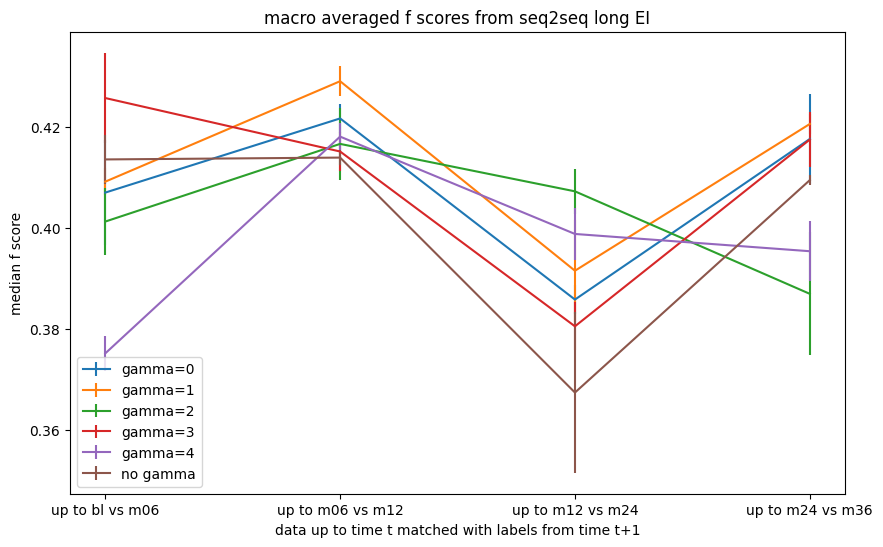

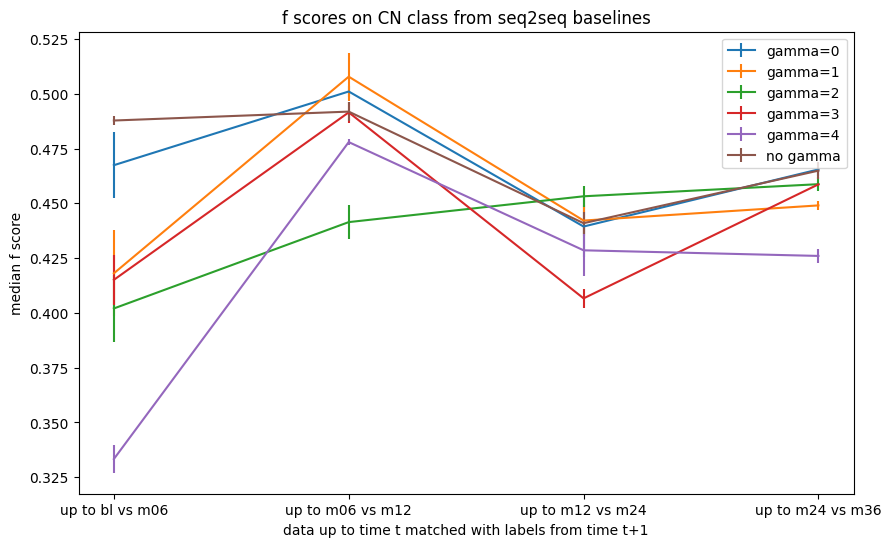

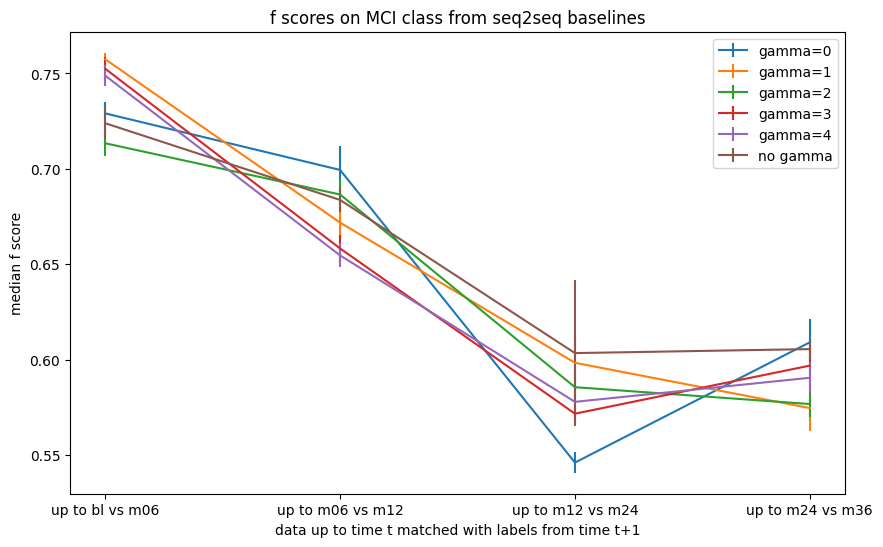

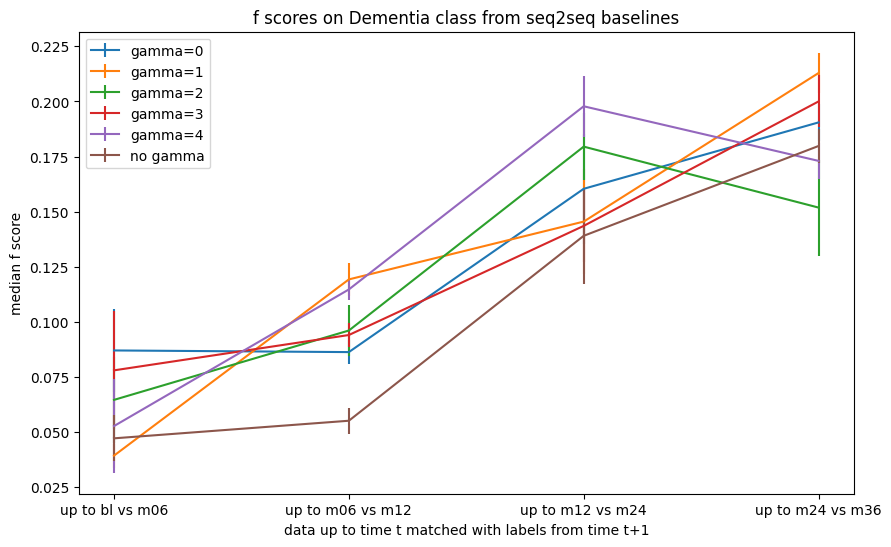

In [44]:
plot_class_scores(score_dict=f_scores_gamma, dict_name='f', class_to_plot='all')
plot_class_scores(score_dict=f_scores_gamma, dict_name='f', class_to_plot='CN')
plot_class_scores(score_dict=f_scores_gamma, dict_name='f', class_to_plot='MCI')
plot_class_scores(score_dict=f_scores_gamma, dict_name='f', class_to_plot='Dementia')

In [ ]:
plot_class_scores(score_dict=p_scores_gamma_weighted, dict_name='p', class_to_plot='all')
plot_class_scores(score_dict=r_scores_gamma_weighted, dict_name='r', class_to_plot='all')

In [45]:
with open("/Users/susmaa01/Documents/eipy/longitudinal_tadpole/results/gamma_tuning/no_sampling_argmax_EI_fixed.pkl", "wb") as file:
    pkl.dump(obj=gamma_results, file=file)

In [ ]:
plot_class_scores(score_dict=p_scores_gamma, dict_name='precision', class_to_plot='all')
plot_class_scores(score_dict=p_scores_gamma, dict_name='precision', class_to_plot='CN')
plot_class_scores(score_dict=p_scores_gamma, dict_name='precision', class_to_plot='MCI')
plot_class_scores(score_dict=p_scores_gamma, dict_name='precision', class_to_plot='Dementia')

In [ ]:
plot_class_scores(score_dict=r_scores_gamma, dict_name='recall', class_to_plot='all')
plot_class_scores(score_dict=r_scores_gamma, dict_name='recall', class_to_plot='CN')
plot_class_scores(score_dict=r_scores_gamma, dict_name='recall', class_to_plot='MCI')
plot_class_scores(score_dict=r_scores_gamma, dict_name='recall', class_to_plot='Dementia')

In [ ]:
# f_score_arrays_train = {k: np.stack(v, axis=0) for k,v in f_scores_train.items()}
# plot_class_scores(score_dicts=f_score_arrays_train, class_to_plot='all')
# plot_class_scores(score_dicts=f_score_arrays_train,class_to_plot='CN')
# plot_class_scores(score_dicts=f_score_arrays_train,class_to_plot='MCI')
# plot_class_scores(score_dicts=f_score_arrays_train, class_to_plot='Dementia')

In [ ]:
# plot_class_scores(score_dicts=f_scores_normal_loss, class_to_plot='all')
# plot_class_scores(score_dicts=f_scores_normal_loss,class_to_plot='CN')
# plot_class_scores(score_dicts=f_scores_normal_loss,class_to_plot='MCI')
# plot_class_scores(score_dicts=f_scores_normal_loss, class_to_plot='Dementia')